https://www.cs.toronto.edu/~kriz/cifar.html


## Experiment 3:  CIFAR-10 podaci sa različitim klasama
- Menjamo m/n odnos. 
- Koristimo matricu A.
- Koristimo Haar transformaciju nad ulaznim slikama

Treniramo mrezu sa objektima koji pripadaju vozilima, a testiramo na objektima iz klase zivotinja.


In [0]:
import pywt
import pickle

import numpy as np
import h5py
from matplotlib import pyplot as plt

from keras.layers import *
from keras.models import *
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
import keras.backend as K

from sklearn.model_selection import train_test_split



### Ucitavanje CIFAR-10

In [0]:
def unpickle(file):    
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



imdata = None
imlabels = None
for i in range(5):
    b = unpickle(''.join(['data_batch_', str(i+1)]))  
    imdata = b[b'data'] if imdata is None else np.vstack((imdata, b[b'data']))
    lbl = b[b'labels']
    lbl = np.reshape(np.array(lbl), (len(lbl),1))
    imlabels = lbl if imlabels is None else np.vstack((imlabels, lbl))
    
imlabels = np.reshape(imlabels, (imlabels.shape[0], ))



print(imlabels[indx])

animal_class = [2, 3, 4, 5, 6, 7]
vehicle_class = [0, 1, 8, 9]

print(imlabels.shape)
print(imdata.shape)

vehicle_imdata = None
for i in vehicle_class:
    im = imdata[imlabels == i]
    vehicle_imdata = im if vehicle_imdata is None else np.vstack((vehicle_imdata, im))

indx_vehicle_imdata = range(vehicle_imdata.shape[0])    
indx_vehicle_imdata = np.random.permutation(indx_vehicle_imdata)
print(indx_vehicle_imdata)
vehicle_imdata = vehicle_imdata[indx_vehicle_imdata]


    
animal_imdata = None
for i in animal_class:
    im = imdata[imlabels == i]
    animal_imdata = im if animal_imdata is None else np.vstack((animal_imdata, im))

indx_animal_imdata = range(animal_imdata.shape[0])    
indx_animal_imdata = np.random.permutation(indx_animal_imdata)
print(indx_animal_imdata)
animal_imdata = animal_imdata[indx_animal_imdata]

3
(50000,)
(50000, 3072)
[ 5308 10441  4979 ... 17096 19064 10273]
[26483 20199 10462 ... 25204 14267  7620]


### Rad sa slikama, konverzija iz RGB u Gray i slicno

In [0]:
# Slika se u CIFAR 10 cuva na sledeci nacin:
# 10000 instanci x 3072 piksela
# 3072 piksela su [1024 crvena, 1024 zelena, 1024 plava]
# Dimenzija slike je 32x32x3 gde prvih 32 odg prvom redu

def convert_to_input_data(in_arr):
    y = np.zeros((in_arr.shape[0], 32, 32, 1))

    for i in range(in_arr.shape[0]):
        u = in_arr[i]
        u_tilda = rgb2gray(u)
        x0 = u_tilda
        y[i, :, :, :] = np.reshape(x0, (32, 32, 1))

    return y


# Konverzija RGB u sivu sliku
def rgb2gray(rgb):
    rgb = rgb.astype(float)/255.0
    im1 = rgb.reshape((3, 1024))
    r, g, b = im1[0], im1[1], im1[2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray


# Haar transformacija nad sivom slikom
# https://pywavelets.readthedocs.io/en/latest/ref/2d-decompositions-overview.html
def perform_Haar(u_tilda):
    u_tilda = np.reshape(u_tilda,(32, 32))
    c = pywt.wavedec2(u_tilda, 'haar', level=3)
    arr, slices = pywt.coeffs_to_array(c)
    x0 = arr
    return x0


# https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.random.choice.html
def create_artificial_data():
    N = 1024
    x0 = np.random.choice([-1, 0, 1], size=1024, p=[0.05, 0.9, 0.05])
    x0 = np.reshape(x0, (32, 32))
    return x0


def create_A(shapeA):
    m, n = shapeA[0], shapeA[1]
    sigma2 = 1/m
    A = np.sqrt(sigma2) * np.random.randn(m, n)
    return A



### Pravljenje modela

In [0]:
def build_CNN_model(image_shape):
    print(image_shape)
    x_input = Input(image_shape)
    x = x_input
    
    for i in range(2):
        x = Conv2D(16, (5, 5), activation='relu', kernel_regularizer=l2(0.01), padding='same')(x) 
        x = Conv2D(16, (5, 5), activation='relu', kernel_regularizer=l2(0.01), padding='same')(x)
        x = BatchNormalization()(x) # Batch normalizacija unutrasnja normalizacija
        x = Activation('relu')(x)
        x = MaxPool2D((2,2))(x)

    x = Flatten()(x)  # razvlacenje da bismo imali adekvatan ulaz u mrezu sa propagacijom 
    x = Dense(1024, activation='linear', kernel_regularizer=l2(0.01))(x)
    x_kappa = Reshape((32, 32, 1))(x)
    
    model = Model(inputs=x_input, outputs=x_kappa, name = 'CNN')
#     model.summary()
    
    # Model ocekuje odgovarajuci ulaz i odgovarajuci izlaz, a na osnovu transformacija koje su koriscene da bi se 
    # od ulaza dobio odgovarajuci izlaz kreira medjuslojeve  
    return model


# https://keras.io/getting-started/sequential-model-guide/

# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
  

def build_VAE(image_size):
    
    # network parameters
    original_dim = image_size*image_size
    input_shape = (original_dim,)
    latent_dim = 100
    
    # encoder model
    inputs = Input(shape=(image_size, image_size, 1), name='encoder_input')    
    x = Flatten()(inputs)  
    for i in range(2):
        x = Dense(400, kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    
    # generate latent vector Q(z|X)
    z_mean = Dense(latent_dim, name='z_mean', kernel_regularizer=l2(0.01))(x)
    z_log_var = Dense(latent_dim, name='z_log_var', kernel_regularizer=l2(0.01))(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    # decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = latent_inputs
    for i in range(2):
        x = Dense(400, kernel_regularizer=l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
    x = Dense(original_dim, kernel_regularizer=l2(0.01))(x)   
    outputs = Reshape((image_size, image_size, 1))(x)
    decoder = Model(latent_inputs, outputs, name='decoder' )
    
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')    
#     vae.summary()
    
    return vae


  

### Funkcija greške i metrika za računanje tačnosti

In [0]:
def c_loss(y_true,y_pred):
    diff = (K.batch_flatten(y_true)-K.batch_flatten(y_pred))
    diff = K.pow(diff, 2)
    diff = K.abs(diff)
    norm2 = K.sum(diff, axis=(1))
    loss = K.mean(norm2)
    return loss


def metric_acc(y_true, y_pred):
    x_norm_2_pow_2 = (K.batch_flatten(y_true)-K.batch_flatten(y_pred))**2
    x_norm_2_pow_2 = K.sum(x_norm_2_pow_2, axis = -1)
    
    x0_norm_2_pow_2 = K.batch_flatten(y_true)**2
    x0_norm_2_pow_2 = 0.05*K.sum(x0_norm_2_pow_2, axis = -1)
    
    bool_tensor = K.cast(K.less_equal(x_norm_2_pow_2, x0_norm_2_pow_2), dtype='float32')
    acc = K.mean(bool_tensor)

    return acc       



## Experiment 3:
- Menjamo m/n odnos. 
- Koristimo matricu A.
- Koristimo Haar transformaciju nad ulaznim slikama

Treniramo mrezu sa objektima koji pripadaju vozilima, a testiramo na objektima iz klase zivotinja.



In [0]:
def prepare_sets_exp1(y_lab, A, use_Haar):
    x = np.zeros(y_lab.shape)
    for i in range(y_lab.shape[0]):
        x0 = y_lab[i, :, :, 0]
        if use_Haar is True:
            x0 = perform_Haar(x0)
        y = np.matmul(A, x0)
        x[i, :, :, 0] = np.matmul(A.T, y)
    return x


in_shape = (32, 32, 1)
N_train, N_val, N_test = 2000, 1000, 1000


x_test_arr = animal_imdata[:N_test, :]

x_train_arr, x_val_arr, y_train_arr, y_val_arr = train_test_split(vehicle_imdata, vehicle_imdata, 
                                                                  train_size = N_train, 
                                                                  test_size=N_val,
                                                                 random_state=42)

y_train = convert_to_input_data(x_train_arr)
y_val = convert_to_input_data(x_val_arr)
y_test = convert_to_input_data(x_test_arr)



n = 32
cnn_res_exp3 = list()
vae_res_exp3 = list()

for m_div_n in np.linspace(0.2, 1, num=5):
        
    m = int(m_div_n*n)
    print("New m_div_n, n={0}, m={1}".format(n, m))
    
    print("Create A")
    A = create_A((m, n))
   
    print("Prepare train/val/test sets")
    x_train = prepare_sets_exp1(y_train, A, True)
    x_val = prepare_sets_exp1(y_val, A, True)
    x_test = prepare_sets_exp1(y_test, A, True)
        
    print("Build CNN model")
    cnn_model = build_CNN_model(in_shape)
    cnn_model.compile(loss=c_loss, optimizer='adam', metrics=[metric_acc])
    
    print("Start trainig CNN")
    cnn_model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                  epochs=100, batch_size=32, verbose=0, 
                  callbacks = [
                        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0000001, verbose=0),
                  ])
    res = cnn_model.evaluate(x_test[:, :, :, :], y_test[:, :, :, :])
    
    print("Evaluacija CNN modela: {0}".format(res))
    cnn_res_exp3.append((m_div_n, res[1]))    
    
    print("Build VEA model")
    vae_model = build_VAE(in_shape[0])
    vae_model.compile(loss=c_loss, optimizer='adam', metrics=[metric_acc])

    print("Start trainig VAE")
    vae_model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                  epochs=300, batch_size=32, verbose=0, 
                  callbacks = [
                        ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0000001, verbose=0),
                  ])
    res = vae_model.evaluate(x_test[:, :, :, :], y_test[:, :, :, :])
    
    print("Evaluacija VEA modela: {0}".format(res))
    vae_res_exp3.append((m_div_n, res[1]))
    

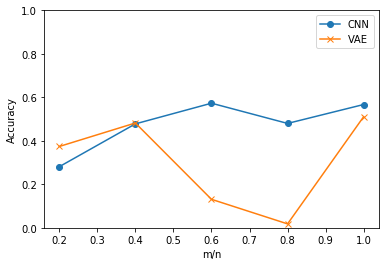

In [0]:
cnn_res_exp3_np = np.array(cnn_res_exp3)
vae_res_exp3_np = np.array(vae_res_exp3)

plt.figure()
plt.plot(cnn_res_exp3_np[:,0], cnn_res_exp3_np[:,1], '-o', label='CNN')
plt.plot(vae_res_exp3_np[:,0], vae_res_exp3_np[:,1], '-x', label='VAE')
plt.ylim([0, 1])
plt.xlabel("m/n")
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Vidimo da CNN i VAE rade lošije od eksperimenta 1. To je zato što su neuronske mreže sposobne da generalizuju, ali nedovoljna raznolikost u trening podacima degradira performanse.
Ovo nije iznenađujuće, kao i da slike iz klase životinja nisu drastično različite prirode od slika iz klase vozila.